## A.3: Final Report: SOTU

### Load Libraries

In [16]:
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import os
wd = os.getcwd()
wd_new = wd +'/nltk_data' #creating a new working directory path for stopwords files

import nltk
nltk.download('stopwords',download_dir=wd_new) 
nltk.download('wordnet',download_dir=wd_new)
nltk.data.path.append(wd_new)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import MDS

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

import pandas as pd

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aliagowani/Documents/GitHub/NU_453_NLP/nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aliagowani/Documents/GitHub/NU_453_NLP/nltk_dat
[nltk_data]     a...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
# Functionality to turn stemming on or off
STEMMING = False
NGRAM_LENGTH = 2

#### Pandas Parameters

In [18]:
#pandas parameters
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)

In [19]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Data Prep

### Function to process documents

In [20]:
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    file_stopwords = pd.read_csv("https://raw.githubusercontent.com/ksenluu/NU_453_NLP/master/Data/english",header=None)
    file_stopwords = file_stopwords[0].values.tolist()
    new_stopwords = ['effect','years','great','today','tonight','congress','freedom','united','states','united states'
                     ,'americans','america','american','americas','government','people','world','shall','would'
                     ,'nations','national','nation','country','state','public','policy'] #remove repeating terms
       
    new_stopwords= new_stopwords+file_stopwords
    stop_words = stop_words.union(new_stopwords)
    tokens = [w for w in tokens if not w in stop_words]        
    # word stemming    
    #if STEMMING:
        #ps=PorterStemmer()
        #tokens=[ps.stem(word) for word in tokens]
    # Lemmatization to account for things like plurals
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(token) for token in tokens]
    
    return tokens

###   Functions to label encoding

In [21]:
def One_Hot(variable):
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels, LE, OHE

In [22]:
# read data
data = pd.read_csv("https://raw.githubusercontent.com/ksenluu/NU_453_NLP/master/Data/sotu_corpus_small.csv")


In [23]:
# new data frame with split value columns 
new = data["DSI_Title"].str.split("_", n = 1, expand = True) 
  
# making separate President_Name column from new data frame 
data["President_Name"] = new[0] 
  
# making separate Year_SOTU column from new data frame 
data["Year_SOTU"] = new[1] 
  
new = data["Year_SOTU"].str.split(".", n = 1, expand = True) 
data["Year_SOTU"] = new[0] 

# df display 
data.shape
data.head(5) 

(102, 5)

,Unnamed: 0,DSI_Title,Text,President_Name,Year_SOTU
0,0,Reagan_1982.txt,"Mr. Speaker, Mr. President, distinguished Memb...",Reagan,1982
1,1,Wilson_1914.txt,GENTLEMEN OF THE CONGRESS: The session upon w...,Wilson,1914
2,2,Madison_1814.txt,Fellow-Citizens of the Senate and House of Rep...,Madison,1814
3,3,Johnson_1969.txt,"Mr. Speaker, Mr. President, Members of the Con...",Johnson,1969
4,4,Hoover_1930.txt,To the Senate and House of Representatives: I...,Hoover,1930


### Processing text into lists

In [24]:
# create empty list to store text documents titles
titles=[]

#for loop which appends the DSI title to the titles list
for i in range(0,len(data)):
    temp_text=data['DSI_Title'].iloc[i]
    titles.append(temp_text)
# create empty list to store text documents
text_body=[]

# for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_text=data['Text'].iloc[i]
    text_body.append(temp_text)

# Note: the text_body is the unprocessed list of documents read directly form the csv.
# empty list to store processed documents
processed_text=[]
#for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)
# stitch back together individual words to reform body of text
final_processed_text=[]

for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)
# Length of full tokenized corpus
len(temp_text)

25293

## Wordcloud

In [25]:
#pip install wordcloud

In [26]:
# rerun stopwords to object
stop_words = set(stopwords.words('english'))
file_stopwords = pd.read_csv("https://raw.githubusercontent.com/ksenluu/NU_453_NLP/master/Data/english",header=None)
file_stopwords = file_stopwords[0].values.tolist()
new_stopwords = ['effect','years','great','today','tonight','congress','freedom','united','states','united states'
                     ,'americans','america','american','americas','government','people','world','shall','would'
                     ,'nations','national','nation','country','state','public','policy'] #remove repeating terms
       
new_stopwords= new_stopwords+file_stopwords
stop_words = stop_words.union(new_stopwords)

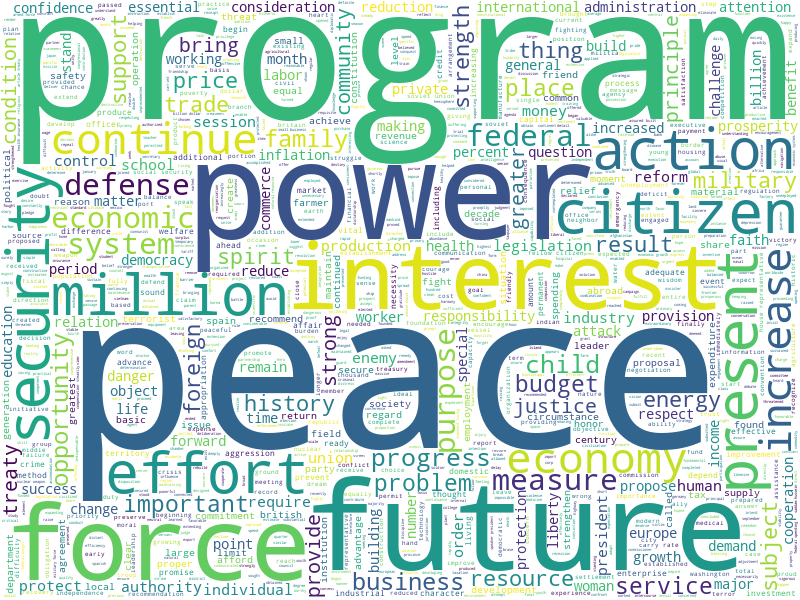

In [27]:
# wordcloud
from wordcloud import WordCloud
final_processed_text_copy = final_processed_text.copy()
long_string = ','.join(final_processed_text_copy)
wordcloud = WordCloud(background_color="white",
                      width=800, height=600,
                      stopwords=stop_words,
                      max_words=5000, 
                      contour_width=3, 
                      contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

### Sklearn TFIDF 
note the ngram_range will allow you to include multiple words within the TFIDF matrix

In [28]:
# call Tfidf Vectorizer
Tfidf=TfidfVectorizer(ngram_range=(1,3), max_df=0.80, max_features=50000)


#fit the vectorizer using final processed documents.  The vectorizer requires the 
#stiched back together document.
final_processed_text_tfidf = final_processed_text.copy()
TFIDF_matrix=Tfidf.fit_transform(final_processed_text_tfidf)

#creating datafram from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)

In [29]:
# Verify TFIDF_Matrix has been created.
matrix.shape
matrix.head()

(102, 50000)

,aaron,abandon,abandon iraqi,abandoned,abandoning,abandonment,abatement,abdicated,abdication,abide,abiding,ability,ability compete,ability negotiate,ability president,abject,ablebodied,aboard,abolish,abolished,abolishing,abolition,abolition slavery,abortion,abortion human,abounds,abraham,abraham lincoln,abraham lincoln warned,abridged,abroad,abroad order,abroad strength,abroad strong,absence,absence appropriation,absolute,absolutely,absolutely clear,absolutely vital,absorb,absorbed,absorption,abstinence,abstract,abundance,abundant,abundant fruit,abundantly,abundantly clear,abuse,abuse grown,abuse place,abuse result,abused,academy,academy point,accede,acceded,accelerate,accelerated,accelerating,acceleration,accept,accept change,accept responsibility,acceptable,acceptance,acceptance volunteer,accepted,accepted peace,accepting,access,access coverage,access market,access opportunity,accessible,accident,accidental,accommodate,accommodating,accommodation,accommodation president,accommodation provided,accompanied,accompany,accomplish,accomplish object,accomplish purpose,accomplish thing,accomplished,accomplishing,accomplishing object,accomplishing purpose,accomplishment,accomplishment decade,accord,accordance,accordance interpretation,accordance interpretation treaty,accorded,account,account district,account district columbia,account money,account receipt,account receipt expenditure,account revenue,account revenue expenditure,account younger,account younger worker,accountability,accountability result,accountable,accounted,accounted material,accounted material evidence,accounting,accredited,accrue,accrued,accrued exceeds,accruing,accruing business,accumulate,accumulated,accumulating,accumulation,accumulation surplus,accumulation surplus revenue,accuracy,accurate,accurately,accused,accused crime,accustomed,achieve,achieve continue,achieve dream,achieve energy,achieve energy goal,achieve energy independence,achieve future,achieve goal,achieve greater,achieve historic,achieve peace,achieve result,achieve thing,achieved,achieved greatest,achievement,achievement ahead,achievement failure,achievement patriotic,achievement purpose,achieving,achieving balanced,achieving balanced budget,achieving energy,achieving energy independence,achieving peace,acknowledge,acknowledged,acknowledged provided,acknowledgement,acknowledging,acknowledgment,acknowledgment supreme,acquainted,acquiescence,acquire,acquire force,acquired,acquires,acquiring,acquisition,acre,acted,acting,acting article,acting article treaty,acting authority,action,action action,action behalf,action called,action complete,action completed,action deemed,action demand,action demanded,action department,action ensure,action europe,action executive,action federal,action force,action improve,action increase,action matter,action measure,action necessity,action needed,action power,action president,action private,action program,action proper,action protect,action reduce,action reform,action required,action responsibility,action senate,action session,action vital,action word,active,active defense,active force,active service,actively,actively engaged,activist,activist judge,activity,activity complete,activity department,activity important,actual,actual estimated,actual experience,actual payment,actual reduction,actual remaining,actual remaining quarter,actual service,actuated,acute,acutely,acutely affected,adam,adapt,adapted,adapted principle,adapting,added,added million,addict,...,western water,westward,wewill,wewill choose,wewill choose place,whats,whatsoever,wheat,wheel,whilst,whilst expenditure,white,white house,white house december,white house february,wholehearted,wholesale,wholesale dealer,wholesale price,wholesome,wholly,whove,wibberley,wicked,widely,widely shared,widely shared prosperity,widen,widening,wider,wider enjoyment,wider field,widespread,widespread hardship,widow,wilderness,wildlife,wilful,wilful deception,wilful deception deceive,willingly,willingness,wilson,wind,wind change,wi

In [30]:
# Get unique names of President_Name to ensure BushW and BusHW were enetered correctly.
data['President_Name'].unique()

array(['Reagan', 'Wilson', 'Madison', 'Johnson', 'Hoover', 'Roosevelt',
       'Truman', 'Kennedy', 'Jefferson', 'Monroe', 'Trump', 'Eisenhower',
       'Obama', 'Adams', 'BushHW', 'Cleveland', 'Grant', 'Washington',
       'Ford', 'BushW', 'Nixon', 'Carter', 'Arthur'], dtype=object)

(<Figure size 1368x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1d329310>)

Text(0.5, 0, 'President Name')

Text(0, 0.5, 'Count of SOTU')

Text(0.5, 1.0, 'US: State of the Union Speeches (SOTU)')

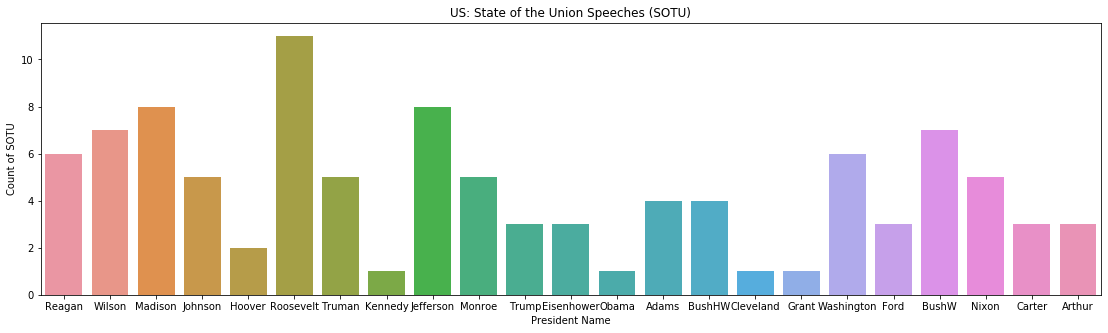

In [31]:
# Simple plot to show the number of SOTU speeches by President Name

import seaborn as sns

plt.subplots(figsize=(19,5))
ax = sns.countplot(x="President_Name", data=data)
# plt.savefig("plot-president_name.pdf", bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', orientation='portrait', papertype=None, format=None, pad_inches=0.25)
plt.xlabel('President Name')
plt.ylabel('Count of SOTU')
plt.title('US: State of the Union Speeches (SOTU)')
plt.show()

### Explore Frequent Terms

In [19]:
# Creating dataframe from CV Matrix
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(ngram_range=(1,3))
final_processed_text_cv = final_processed_text.copy()
cv_matrix=cv.fit_transform(final_processed_text_cv)    
cv_matrix=pd.DataFrame(cv_matrix.toarray(), columns=cv.get_feature_names(), index=titles)   

In [20]:
# Trying few things out (Ali) 

# Create transposed dataframe from CV Matrix
matrix_corp_t = matrix.transpose()
cv_matrix_corp_t = cv_matrix.transpose() 

# Sum all the terms to create Term Frequency and Document Frequency for each term
cv_matrix_corp_t['df_corpus']= (cv_matrix_corp_t != 0).sum(axis=1)
cv_matrix_corp_t['tf_corpus']= cv_matrix_corp_t.sum(axis=1) - cv_matrix_corp_t['df_corpus']

# Remove uncessary columns from the dataframe after summing them
idx = np.r_[0:102]
cv_matrix_corp_t.drop(cv_matrix_corp_t.columns[idx], axis=1, inplace=True)

print("Top 10 Terms based on document frequency.")
print(cv_matrix_corp_t[['df_corpus']].nlargest(20, 'df_corpus'))
print("\n")
print("Top 10 Terms based on frequency.")
print(cv_matrix_corp_t[['tf_corpus']].nlargest(20, 'tf_corpus'))

Top 10 Terms based on document frequency.
           df_corpus
power             97
peace             95
force             93
interest          93
citizen           89
progress          89
system            89
future            86
present           86
service           86
mean              85
place             85
important         83
military          83
security          83
house             82
purpose           82
union             82
million           81
order             81


Top 10 Terms based on frequency.
          tf_corpus
peace           709
power           533
program         482
force           463
security        433
citizen         421
federal         413
million         408
economic        399
future          385
interest        378
system          343
defense         331
present         328
economy         324
military        320
effort          315
budget          309
action          301
child           298


### Explore TFIDF Values

In [21]:
average_TFIDF={}
for i in matrix.columns:
    average_TFIDF[i]=np.mean(matrix[i])

average_TFIDF_DF=pd.DataFrame(average_TFIDF,index=[0]).transpose()

average_TFIDF_DF.columns=['TFIDF']

#calculate Q1 and Q3 range
Q1=np.percentile(average_TFIDF_DF, 25)
Q3=np.percentile(average_TFIDF_DF, 75)
IQR = Q3 - Q1
outlier=Q3+(1.5*IQR)

#words that exceed the Q3+IQR*1.5
outlier_list=average_TFIDF_DF[average_TFIDF_DF['TFIDF']>=outlier]

In [22]:
outlier_list.shape

(5632, 1)

### Gensim Word2vec 
Note, there are opportunities to use the word2vec matrix to determine words which are similar.  Similar words can be used to create equivalent classes.  
k-means is not used to group individual words using the Word2Vec output.

In [23]:
#word to vec
model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

#join all processed DSI words into single list
processed_text_w2v=[]
for i in processed_text:
    for k in i:
        processed_text_w2v.append(k)

#obtian all the unique words from DSI
w2v_words=list(set(processed_text_w2v))

#can also use the get_feature_names() from TFIDF to get the list of words
#w2v_words=Tfidf.get_feature_names()

#empty dictionary to store words with vectors
w2v_vectors={}

#for loop to obtain weights for each word
for i in w2v_words:
    temp_vec=model_w2v.wv[i]
    w2v_vectors[i]=temp_vec

#create a final dataframe to view word vectors
w2v_df=pd.DataFrame(w2v_vectors).transpose()

### K Means Clustering - TFIDF
the following section runs applies the k-means algorithm on the TFIDF matrix.

[KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
        n_clusters=1, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
        n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
        n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
        n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
        n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=None, tol=0.0001, verbose=0),
 KMeans(algorit

[-92.4950354453661,
 -88.34925269442687,
 -86.43488332545681,
 -85.02595480387889,
 -83.81665172088057,
 -82.37992136957972,
 -81.14029697424623]

Text(0.5, 0, 'Number of Clusters')

Text(0, 0.5, 'Score')

Text(0.5, 1.0, 'Elbow Method')

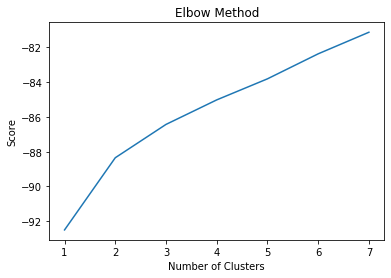

In [24]:
number_clusters = range(1, 8)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(TFIDF_matrix).score(TFIDF_matrix) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

In [25]:
k=6
km = KMeans(n_clusters=k, random_state =89)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()

final_processed_text_copy = final_processed_text.copy()
terms = Tfidf.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text_copy}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])


print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :15]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=89, tol=0.0001, verbose=0)

Top terms per cluster:
Cluster 0:


(None,)

treaty
 commissioner
 majesty
 subject
 award
 mexico
 appointed
 vessel
 republic
 territory
 convention
 claim
 gentleman
 chile
 relation
Cluster 0 titles: Wilson_1913.txt, Adams_1799.txt, Grant_1872.txt, Washington_1796.txt, Adams_1797.txt, Arthur_1883.txt, Arthur_1882.txt, Arthur_1881.txt,Cluster 1:


(None,)

terrorist
 child
 iraqi
 worker
 health
 family
 reform
 school
 economy
 budget
 woman
 terror
 regime
 saddam
 fight
Cluster 1 titles: Trump_2017.txt, Obama_2016.txt, BushHW_1992.txt, BushHW_1991.txt, BushHW_1990.txt, Trump_2019.txt, Trump_2018.txt, BushW_2005.txt, BushW_2004.txt, BushW_2006.txt, BushW_2007.txt, BushW_2003.txt, BushW_2002.txt, BushW_2001.txt,Cluster 2:


(None,)

industrial
 economic
 democracy
 labor
 problem
 action
 price
 federal
 business
 method
 production
 relief
 recovery
 industry
 condition
Cluster 2 titles: Hoover_1930.txt, Hoover_1932.txt, Wilson_1916.txt, Roosevelt_1938.txt, Roosevelt_1939.txt, Cleveland_1887.txt, Roosevelt_1943.txt, Roosevelt_1942.txt, Roosevelt_1944.txt, Roosevelt_1937.txt, Wilson_1920.txt, Roosevelt_1936.txt, Roosevelt_1934.txt, Roosevelt_1935.txt, Wilson_1918.txt, Wilson_1919.txt,Cluster 3:


(None,)

british
 commerce
 subject
 vessel
 spain
 militia
 object
 provision
 indian
 tribe
 consideration
 treaty
 million
 treasury
 measure
Cluster 3 titles: Madison_1814.txt, Madison_1815.txt, Madison_1816.txt, Madison_1812.txt, Madison_1813.txt, Madison_1811.txt, Jefferson_1808.txt, Madison_1810.txt, Monroe_1820.txt, Adams_1798.txt, Monroe_1822.txt, Monroe_1819.txt, Monroe_1818.txt, Washington_1791.txt, Adams_1800.txt, Washington_1793.txt, Washington_1792.txt, Monroe_1817.txt, Washington_1795.txt, Washington_1794.txt, Madison_1809.txt, Jefferson_1805.txt, Jefferson_1804.txt, Jefferson_1806.txt, Jefferson_1807.txt, Jefferson_1803.txt, Jefferson_1802.txt, Jefferson_1801.txt,Cluster 4:


(None,)

program
 federal
 budget
 billion
 soviet
 president
 family
 economic
 growth
 inflation
 spending
 child
 percent
 nuclear
 vietnam
Cluster 4 titles: Reagan_1982.txt, Johnson_1969.txt, Johnson_1968.txt, Reagan_1984.txt, Reagan_1985.txt, Reagan_1987.txt, Kennedy_1963.txt, Reagan_1986.txt, BushHW_1989.txt, Ford_1976.txt, Ford_1977.txt, Ford_1975.txt, Nixon_1972.txt, Nixon_1973.txt, Reagan_1988.txt, Nixon_1971.txt, Nixon_1970.txt, Carter_1980.txt, Johnson_1966.txt, Nixon_1974.txt, Carter_1978.txt, Johnson_1965.txt, Johnson_1964.txt, Carter_1979.txt,Cluster 5:


(None,)

economic
 program
 defense
 strength
 effort
 production
 price
 action
 economy
 thing
 soviet
 people
 development
 continue
 democratic
Cluster 5 titles: Wilson_1914.txt, Wilson_1917.txt, Truman_1949.txt, Truman_1948.txt, Eisenhower_1959.txt, Eisenhower_1958.txt, Roosevelt_1940.txt, Roosevelt_1941.txt, Eisenhower_1957.txt, Truman_1952.txt, Truman_1951.txt, Truman_1950.txt,

### Plotting 
Convert two components as we're plotting points in a two-dimensional plane
"precomputed" because we provide a distance matrix

We will also specify `random_state` so the plot is reproducible.

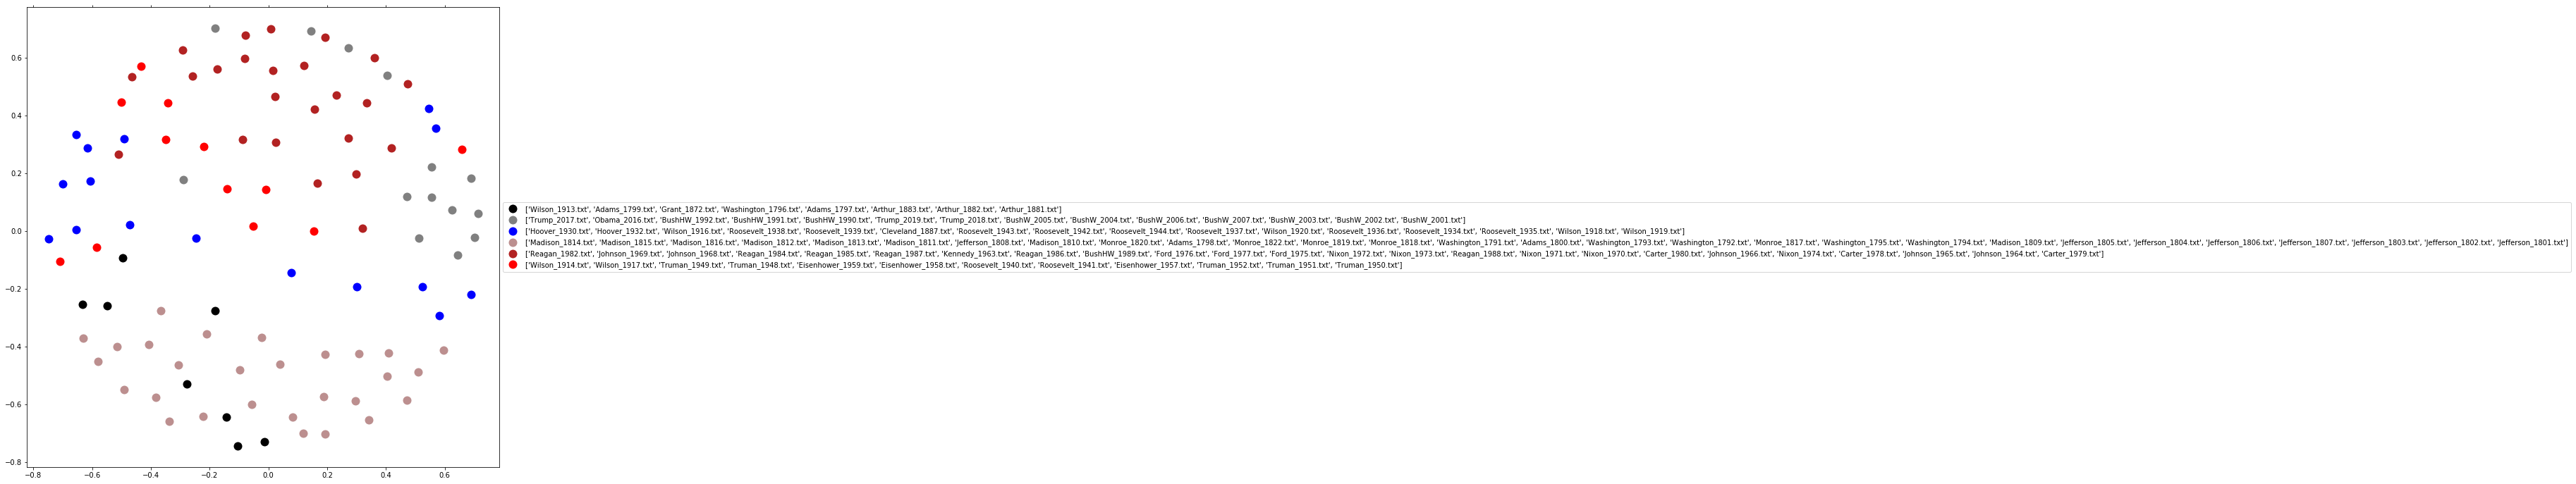

In [27]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(TFIDF_matrix)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 5:'red', 6:'darksalmon', 7:'sienna', 8:'green', 9:'purple', 10:'pink', 11:'yellow'}


#set up cluster names using a dict.  
cluster_dict=cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

In [28]:
#fig.savefig('Images/clusters.png')

In [29]:
model_RF=RandomForestClassifier()

#TFIDF
Y=clusters
X=TFIDF_matrix

#cross validation
cv_score=cross_val_score(model_RF, X,Y, cv=5)

#mean CV score
np.mean(cv_score)

0.737142857142857

### Review Clusters

In [30]:
term_clusters = pd.DataFrame.from_dict(cluster_terms) #pull out terms into a dataframe
terms = term_clusters.stack() #stack terms names into 1 column
terms = terms.reset_index() #move index into a column
terms = terms.rename(columns={'level_1': 'cluster_term', 0:'term'}) #rename columns
terms = terms.drop(['level_0'], axis=1) #drop unecessary column
terms.head()

,cluster_term,term
0,0,treaty
1,1,terrorist
2,2,industrial
3,3,british
4,4,program


In [31]:
# look at frequent terms across clusters
term_clusters

,0,1,2,3,4,5
0,treaty,terrorist,industrial,british,program,economic
1,commissioner,child,economic,commerce,federal,program
2,majesty,iraqi,democracy,subject,budget,defense
3,subject,worker,labor,vessel,billion,strength
4,award,health,problem,spain,soviet,effort
5,mexico,family,action,militia,president,production
6,appointed,reform,price,object,family,price
7,vessel,school,federal,provision,economic,action
8,republic,economy,business,indian,growth,economy
9,territory,budget,method,tribe,inflation,thing


In [32]:
titles = pd.DataFrame.from_dict(cluster_title, orient='index') #convert tiles to a dataframe
titles = titles.stack() #stack document names into 1 column
titles = titles.reset_index() #move index into a column
titles = titles.rename(columns={'level_0': 'cluster_doc', 0:'document'}) #rename columns
titles = titles.drop(['level_1'], axis=1) #drop unecessary column
titles.head()

,cluster_doc,document
0,0,Wilson_1913.txt
1,0,Adams_1799.txt
2,0,Grant_1872.txt
3,0,Washington_1796.txt
4,0,Adams_1797.txt


In [33]:
# join TFIDF values to documents in new dataframe w/ clusters
term_list = terms['term'].values.tolist() #pull all terms into a list
matrix_clustering = matrix[term_list] #pull out only terms in clusters
full_titles = titles.set_index('document').join(matrix_clustering, how='left') # join in tf-idf values
full_titles.shape

(102, 91)

In [34]:
# calculate average tf-idf values for each cluster of terms
for i in range (k):
    full_titles[i] = full_titles[term_clusters[i].values.tolist()].mean(axis=1)

In [35]:
# remove all other columsn leaving only the average 
full_titles = full_titles.set_index('cluster_doc', append=True)
full_titles_final = full_titles[full_titles.columns[-k:]]

<Figure size 360x2160 with 0 Axes>

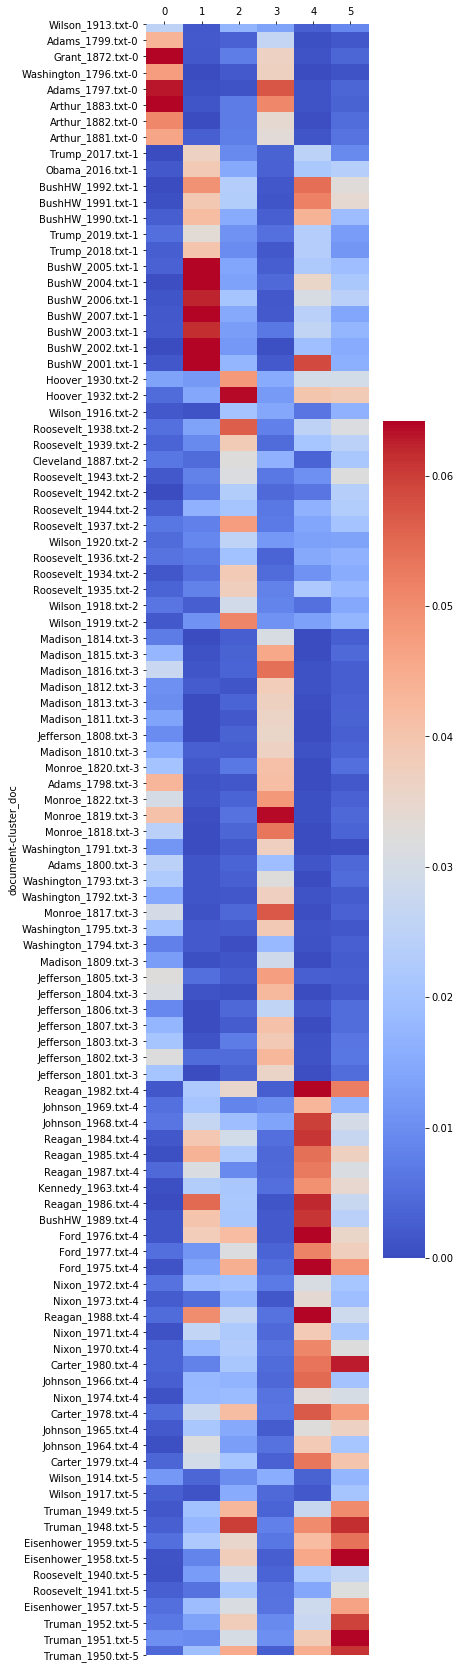

In [36]:
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(5,30))
plt.rcParams['font.size'] = 10
p=sns.heatmap(full_titles_final, cmap='coolwarm', robust=True)
p.xaxis.tick_top()
p.xaxis.set_label_position('top')

In [37]:
p.get_figure().savefig('Images/heatmap_7.png')

# heatmap_1 using 8 clusters, no additional stopwords removed
# heatmap_2 using 8 clusters, reduced term size to 1-2 words, removed frequent words
# heatmap_3 using 6 clusters, reduced term size to 1-2 words, removed frequent words
# heatmap_4 using 6 clusters, reduced term size to 1-3 words, removed frequent words
# heatmap_5 using 6 clusters, reduced term size to 1-2 words, removed frequent words, increased top term size to 15 *BEST*
# heatmap_6 using 6 clsuters, reduced term size to 1-2 words, removed frequent words, increased top term size to 20
# heatmap_7 using 6 clsuters, term size to 1-3 words, removed frequent words, top term size 15

### Comparing Cluster Groupings

In [38]:
# merging dataframes
kl_groups1 = full_titles_final.copy()
kl_groups1 = kl_groups1.reset_index()
k1_groups2 = kl_groups1[['document','cluster_doc']].copy()

data1 = data.copy()
data2 = data1[['DSI_Title','President_Name','Year_SOTU']].copy() 
data2.rename(columns={'DSI_Title':'document'}, inplace=True)

# left join
kl_groups_final = k1_groups2.merge(data2, on ='document', how='left')

print(k1_groups2.shape)
print(data2.shape)
print(kl_groups_final.shape)

(102, 2)
(102, 3)
(102, 4)


In [39]:
# add random variable
kl_groups_final['randNumCol'] = np.random.randint(1, 103, kl_groups_final.shape[0])

# change cluster to be string
kl_groups_final['cluster'] = kl_groups_final['cluster_doc'].astype(str)

kl_groups_final.head()

,document,cluster_doc,President_Name,Year_SOTU,randNumCol,cluster
0,Wilson_1913.txt,0,Wilson,1913,76,0
1,Adams_1799.txt,0,Adams,1799,27,0
2,Grant_1872.txt,0,Grant,1872,76,0
3,Washington_1796.txt,0,Washington,1796,22,0
4,Adams_1797.txt,0,Adams,1797,92,0


In [40]:
pip install plotly -q

Note: you may need to restart the kernel to use updated packages.


In [41]:
import plotly.express as px
fig = px.scatter(kl_groups_final, x="Year_SOTU", y="randNumCol", color="cluster", hover_data=['document']
                 ,width=800, height=600)

fig.update_traces(marker=dict(size=10,
                              opacity=0.8,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
#fig.show()

### K Means Clustering Doc2Vec

The following section of code is to run the k-means algorithm on the doc2vec outputs.
<br/>Note the differences in document clusters compared to the TFIDF matrix.

In [42]:
# create empty list to store text documents titles
titles=[]

#for loop which appends the DSI title to the titles list
for i in range(0,len(data)):
    temp_text=data['DSI_Title'].iloc[i]
    titles.append(temp_text)
# create empty list to store text documents
text_body=[]

# for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_text=data['Text'].iloc[i]
    text_body.append(temp_text)

# Note: the text_body is the unprocessed list of documents read directly form the csv.
# empty list to store processed documents
processed_text=[]
#for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)
# stitch back together individual words to reform body of text
final_processed_text=[]

for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)
# Length of full tokenized corpus
len(temp_text)

25293

In [43]:
final_processed_text_cd2v = final_processed_text.copy()
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text_cd2v)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

doc2vec_df=pd.DataFrame()
for i in range(0,len(processed_text)):
    vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
    doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

doc2vec_df=doc2vec_df.reset_index()

doc_titles={'title': titles}
t=pd.DataFrame(doc_titles)

doc2vec_df=pd.concat([doc2vec_df,t], axis=1)

doc2vec_df=doc2vec_df.drop('index', axis=1)

In [44]:
# creating vector representation of the whole document

doc2vec_k_means=doc2vec_df.drop('title', axis=1)

k=8
km2 = KMeans(n_clusters=k, random_state =89)
km2.fit(doc2vec_k_means)
clusters_d2v = km2.labels_.tolist()

final_processed_text_copy2 = final_processed_text.copy()
Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text_copy2}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

# dictionary to store clusters and respective titles
cluster_title={}

# note doc2vec clusters will not have individual words due to the vector representation
# is based on the entire document not indvidual words. As a result, there won't be individual
# word outputs from each cluster.   
for i in range(k):
    temp=frame[frame['Cluster']==i]
    temp_title_list=[]
    for title in temp['Doc Name']:
        temp_title_list.append(title)
    cluster_title[i]=temp_title_list
    

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=89, tol=0.0001, verbose=0)

In [45]:
cluster_title

{0: ['Madison_1812.txt',
  'Trump_2017.txt',
  'BushHW_1991.txt',
  'Grant_1872.txt',
  'BushW_2004.txt',
  'Wilson_1919.txt'],
 1: ['Madison_1815.txt',
  'Hoover_1932.txt',
  'Reagan_1984.txt',
  'Reagan_1987.txt',
  'Obama_2016.txt',
  'Adams_1798.txt',
  'Monroe_1822.txt',
  'Cleveland_1887.txt',
  'Washington_1793.txt',
  'Ford_1976.txt',
  'Adams_1797.txt',
  'Washington_1794.txt',
  'Roosevelt_1944.txt',
  'Eisenhower_1957.txt',
  'Madison_1809.txt',
  'Truman_1952.txt',
  'BushW_2006.txt',
  'Truman_1951.txt',
  'Truman_1950.txt',
  'BushW_2007.txt',
  'BushW_2003.txt',
  'Arthur_1883.txt',
  'Jefferson_1803.txt',
  'Wilson_1918.txt',
  'Johnson_1965.txt',
  'Jefferson_1801.txt'],
 2: ['Reagan_1982.txt',
  'Hoover_1930.txt',
  'Madison_1811.txt',
  'Jefferson_1808.txt',
  'Roosevelt_1943.txt',
  'Roosevelt_1942.txt',
  'Monroe_1817.txt',
  'Trump_2019.txt',
  'Trump_2018.txt',
  'Jefferson_1804.txt',
  'Roosevelt_1936.txt',
  'Jefferson_1806.txt',
  'Jefferson_1807.txt',
  'Cart

In [46]:
#Doc2Vec
Y=clusters_d2v
X=doc2vec_k_means

#cross validation
cv_score=cross_val_score(model_RF, X,Y, cv=7)

#mean CV score
np.mean(cv_score)

0.30612244897959184

### Plotting Doc2vec
convert two components as we're plotting points in a two-dimensional plane
"precomputed" because we provide a distance matrix
we will also specify `random_state` so the plot is reproducible.

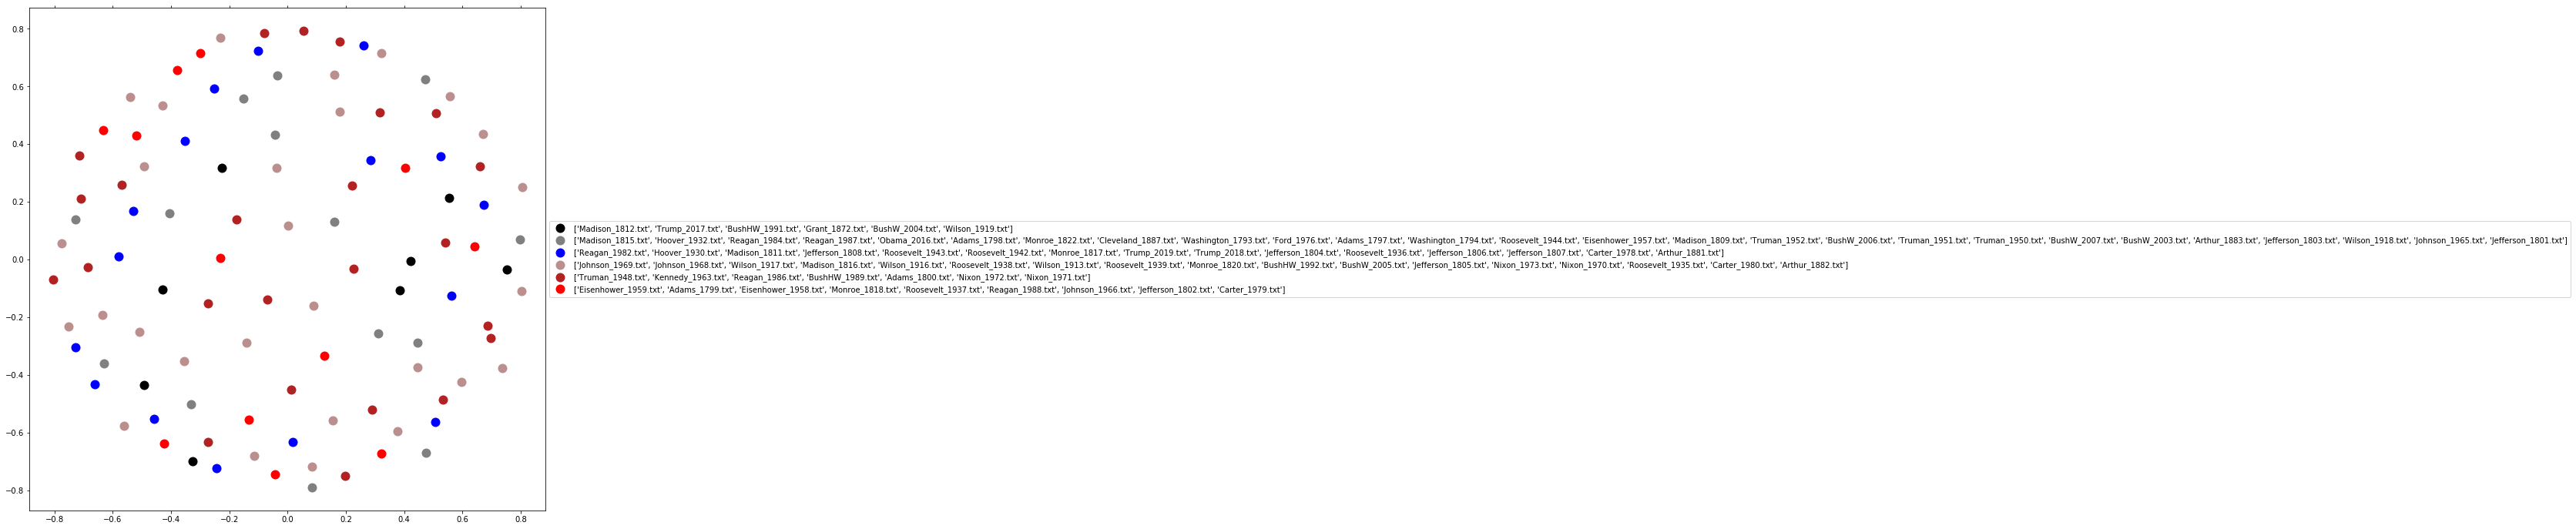

In [47]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(doc2vec_k_means)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                  5:'red', 6:'darksalmon', 7:'sienna'}


#set up cluster names using a dict.  
cluster_dict=cluster_title         

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point

### LDA - topic modeling

In [48]:
# create empty list to store text documents titles
titles=[]

#for loop which appends the DSI title to the titles list
for i in range(0,len(data)):
    temp_text=data['DSI_Title'].iloc[i]
    titles.append(temp_text)
# create empty list to store text documents
text_body=[]

# for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_text=data['Text'].iloc[i]
    text_body.append(temp_text)

# Note: the text_body is the unprocessed list of documents read directly form the csv.
# empty list to store processed documents
processed_text=[]
#for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)
# stitch back together individual words to reform body of text
final_processed_text=[]

for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)
# Length of full tokenized corpus
len(temp_text)

25293

In [49]:
# Topic Modeling
# LDA using bag of words
dictionary = corpora.Dictionary(processed_text)
corpus = [dictionary.doc2bow(doc) for doc in processed_text]

ldamodel = LdaMulticore(corpus, num_topics=6, id2word=dictionary, passes=10, workers=3)    

for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
  File "/Users/aliagowani/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/Users/aliagowani/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/aliagowani/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/aliagowani/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/aliagowani/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/aliagowani/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/aliagowani/opt/anaconda3/lib/python3.7/multiprocessin

KeyboardInterrupt: 

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=processed_text,dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
pip install pyLDAvis -q

In [52]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

NameError: name 'ldamodel' is not defined

In [53]:
#LDA using TFIDF
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
ldamodel = LdaMulticore(corpus_tfidf, num_topics=6, id2word=dictionary, passes=2, workers=2)    

for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Process ForkPoolWorker-7:
Traceback (most recent call last):
  File "/Users/aliagowani/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


KeyboardInterrupt: 

## LSA

In [9]:
pip install textblob -q

Note: you may need to restart the kernel to use updated packages.


In [10]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

In [11]:
for col in data.columns: 
    print(col) 

Unnamed: 0
DSI_Title
Text
President_Name
Year_SOTU


In [12]:
data_sa = data

In [13]:
data_sa.drop(['Unnamed: 0', 'DSI_Title'], axis=1, inplace=True)

In [14]:
# Modify dataframe
data_sa['Year_SOTU'] = data_sa['Year_SOTU'].astype(int)
#df['President_Name'] = potus

#create a list of Democrat presidents
dems = ['Cleveland', 'Johnson', 'Wilson', 'Roosevelt', 'Truman', 'Kennedy', 'Carter', 'Obama']

#add party affiliation to the dataframe
data_sa['party'] = data_sa.President_Name.apply(lambda x: 'Democrat' if x in dems else 'Republican')

In [15]:
data_sa = data_sa[['Year_SOTU', 'President_Name', 'party', 'Text']]

In [16]:
data_sa.rename(columns={'Year_SOTU':'year', 'President_Name':'president', 'Text':'text'}, inplace=True)

In [17]:
data_sa.head()

,year,president,party,text
0,1982,Reagan,Republican,"Mr. Speaker, Mr. President, distinguished Memb..."
1,1914,Wilson,Democrat,GENTLEMEN OF THE CONGRESS: The session upon w...
2,1814,Madison,Republican,Fellow-Citizens of the Senate and House of Rep...
3,1969,Johnson,Democrat,"Mr. Speaker, Mr. President, Members of the Con..."
4,1930,Hoover,Republican,To the Senate and House of Representatives: I...


In [18]:
#use textblob to perform a sentiment analysis of each speech
data_sa['sentiment'] = data_sa['text'].apply(lambda speech: TextBlob(speech).sentiment.polarity)

Text(0.5, 19.799999999999983, 'Year')

Text(25.3660763888889, 0.5, 'Sentiment')

Text(0.5, 1, 'SotU Sentiment Analysis by President')

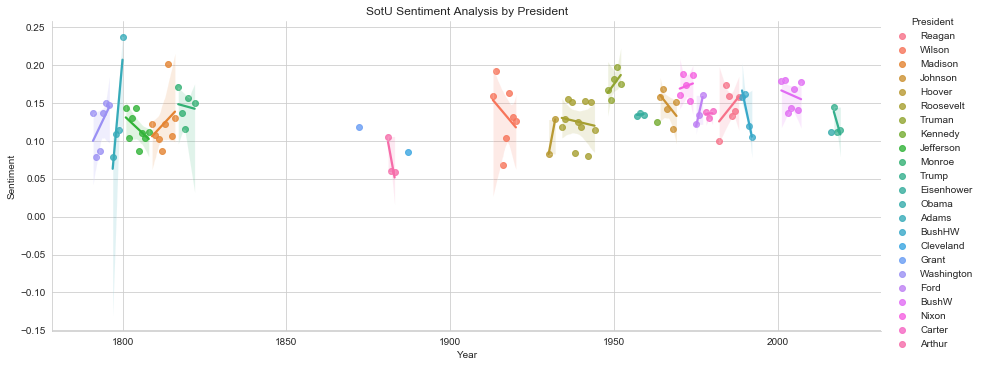

In [19]:
#plot sentiment analysis data
sns.set_style("whitegrid", {'axes.grid' : True})

g = sns.lmplot(x="year", y="sentiment", hue="president", aspect=2.5, truncate=True, data=data_sa)
g._legend.set_title('President')
plt.xlabel('Year')
plt.ylabel('Sentiment')
plt.title('SotU Sentiment Analysis by President')

plt.show()

In [20]:
economic_df = pd.read_csv("https://raw.githubusercontent.com/ksenluu/NU_453_NLP/master/Data/gdp_data.csv")

In [21]:
data_sa = data_sa.merge(economic_df, how='left', on='year')


In [22]:
data_sa.rename(columns={'GDP Growth Rate':'gdp_rate'}, inplace=True)

In [23]:
data_sa = data_sa[data_sa['gdp_rate'].notna()].sort_values('year').reset_index(drop=True)
data_sa.head() 

,year,president,party,text,sentiment,gdp_rate
0,1930,Hoover,Republican,To the Senate and House of Representatives: I...,0.082816,-6.4
1,1932,Hoover,Republican,To the Senate and House of Representatives: I...,0.128491,-1.3
2,1934,Roosevelt,Democrat,"Mr. President, Mr. Speaker, Senators and Repre...",0.118513,8.9
3,1935,Roosevelt,Democrat,"Mr. President, Mr. Speaker, Members of the Sen...",0.128568,12.9
4,1936,Roosevelt,Democrat,"Mr. President, Mr. Speaker, Members of the Sen...",0.154848,5.1


Text(0.5, 19.799999999999983, 'Year')

Text(23.941350694444452, 0.5, '% GDP Growth Rate')

Text(0.5, 1, 'GDP Growth Rate by Year')

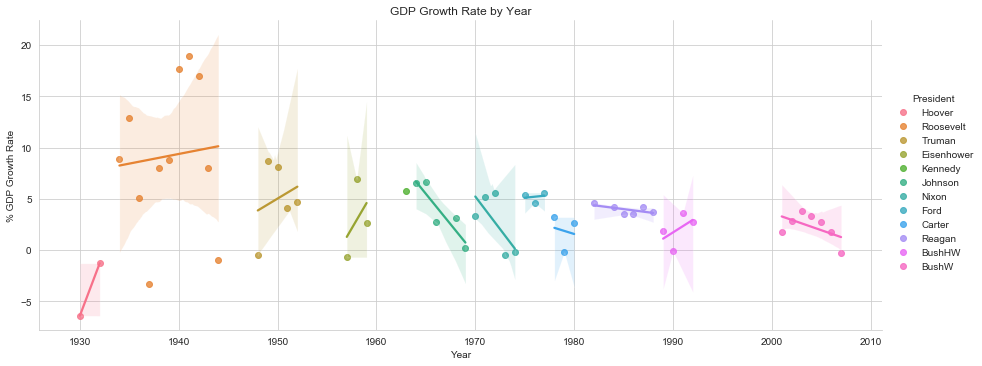

In [24]:
#plot GDP growth data
g1 = sns.lmplot(x="year", y="gdp_rate", hue="president", aspect=2.5, truncate=True, data=data_sa)
g1._legend.set_title('President')
plt.xlabel('Year')
plt.ylabel('% GDP Growth Rate')
plt.title('GDP Growth Rate by Year')

plt.show()

Text(0.5, 1.0, 'SotU Sentiment Analysis by President vs GDP Growth Rate')

Text(0.5, 0, 'Year')

Text(0, 0.5, 'SoTu Sentiment Value')

Text(0, 0.5, '% GDP Growth Rate')

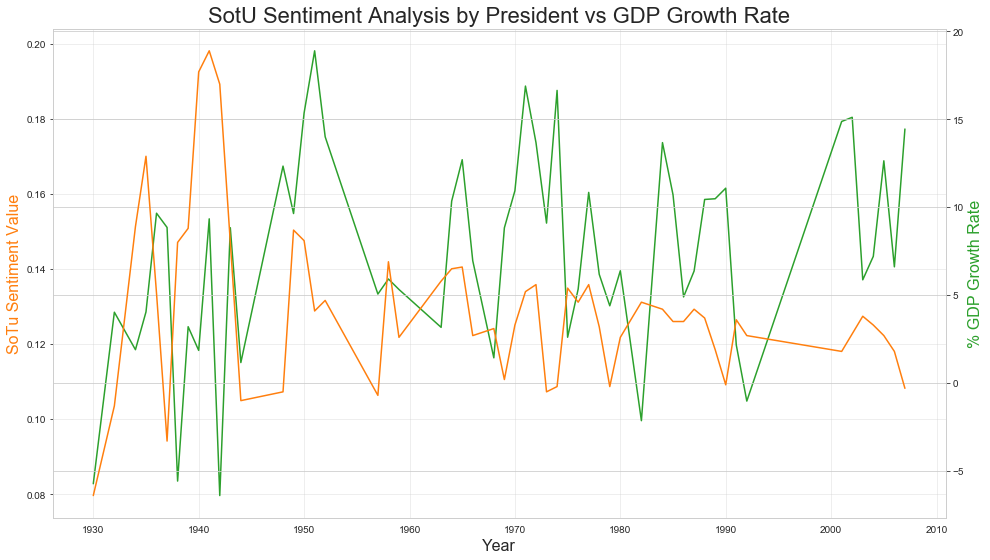

In [25]:
# Set black background
#plt.style.use("dark_background")

# Create combo chart
fig, ax1 = plt.subplots(figsize=(16,9))
# Plot 1 creation
ax1.set_title('SotU Sentiment Analysis by President vs GDP Growth Rate', fontsize=22)

ax2 = sns.lineplot(x='year', y='sentiment', data = data_sa, color='tab:green')
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('SoTu Sentiment Value', fontsize=16, color='tab:orange')
ax1.tick_params(axis='y')

ax1.grid(alpha=.4)

# Specify to share the same x-axis
ax2 = ax1.twinx()

# Plot 2 creation
ax2 = sns.lineplot(x='year', y='gdp_rate', data = data_sa, sort=False, color='tab:orange')
ax2.set_ylabel('% GDP Growth Rate', fontsize=16, color='tab:green')
ax2.tick_params(axis='y')

#show plot
plt.show()

In [26]:
import numpy as np
np.corrcoef(data_sa.sentiment, data_sa.gdp_rate)

array([[ 1.        , -0.14456011],
       [-0.14456011,  1.        ]])

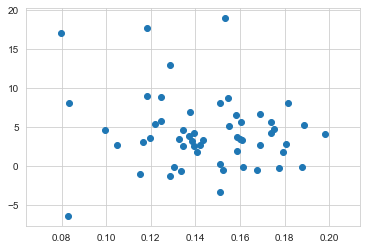

In [27]:
plt.scatter(data_sa.sentiment, data_sa.gdp_rate)
plt.show()

In [28]:
employment_df = pd.read_csv("https://raw.githubusercontent.com/ksenluu/NU_453_NLP/master/Data/unemployment_data.csv")

In [29]:
data_sa_emp = data_sa.merge(employment_df, how='left', on='year')


In [30]:
data_sa_emp['rate'] = data_sa_emp['rate']*100

In [31]:
data_sa_emp.rename(columns={'rate':'unemployment_rate'}, inplace=True)

In [32]:
data_sa_emp = data_sa_emp[data_sa_emp['unemployment_rate'].notna()].sort_values('year').reset_index(drop=True)
data_sa_emp.head() 

,year,president,party,text,sentiment,gdp_rate,unemployment_rate
0,1948,Truman,Democrat,"Mr. President, Mr. Speaker, and Members of the...",0.167392,-0.5,4.0
1,1949,Truman,Democrat,"Mr. President, Mr. Speaker, Members of the Con...",0.154764,8.7,6.6
2,1950,Truman,Democrat,"Mr. President, Mr. Speaker, Members of the Con...",0.181532,8.1,4.3
3,1951,Truman,Democrat,"Mr. President, Mr. Speaker, Members of the Con...",0.198093,4.1,3.1
4,1952,Truman,Democrat,"Mr. President, Mr. Speaker, Members of the Con...",0.175190,4.7,2.7


<Figure size 648x360 with 0 Axes>

Text(0.5, 0, 'Unemployment Rate')

Text(0, 0.5, 'Sentiment')

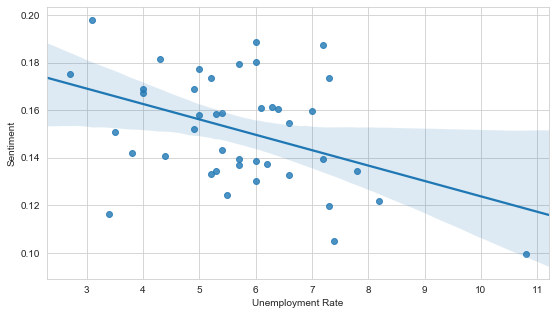

In [33]:
plt.figure(figsize=(9, 5))

#plt.subplot(121)
#sns.regplot(df.gdp_rate, df.sentiment)
#plt.xlabel('GDP Growth Rate')
#plt.ylabel('Sentiment')

#plt.subplot(122)
sns.regplot(data_sa_emp.unemployment_rate, data_sa_emp.sentiment)
plt.xlabel('Unemployment Rate')
plt.ylabel('Sentiment')

plt.show()

In [35]:
from scipy.stats import pearsonr

print('Sentiment-Unemployment Correleation:', pearsonr(data_sa_emp.unemployment_rate, data_sa_emp.sentiment))

Sentiment-Unemployment Correleation: (-0.42414893268908843, 0.005120527843619492)


## Term Frequency by Decade


In [55]:
# Create copy of Matrix 
matrix_decade = matrix.copy()
matrix_decade.index.name = ''
# matrix_decade.head(10)

# Rename Index
matrix_decade.index.name = "DSI_Title"

# Reset Index
matrix_decade = matrix_decade.reset_index()

In [56]:
# Parse string to turn year of SOTU speech to a decade format
matrix_decade['DSI_Title'] = matrix_decade.DSI_Title.str.replace(r"[a-zA-Z._]",'')
matrix_decade['DSI_Title'] = matrix_decade['DSI_Title'].str.slice(0,3)
matrix_decade['DSI_Title'] = matrix_decade['DSI_Title'] + '0'

In [57]:
# Set DSI_Title to index so it can be transformed.
matrix_decade.set_index('DSI_Title', inplace=True)
matrix_decade_t = matrix_decade.transpose()

In [53]:
# Group and sum the terms by decade of SOTU speech
matrix_decade_t = matrix_decade_t.groupby(axis=1, level=0).sum()
matrix_decade_t.head()

DSI_Title,1790,1800,1810,1820,1870,1880,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010
aaron,0.000000,0.037732,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0
abandon,0.020777,0.027894,0.011340,0.0,0.0,0.0,0.000000,0.0,0.046655,0.033003,0.027692,0.037353,0.015001,0.031928,0.01689,0.046969,0.0
abandon iraqi,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.040062,0.0
abandoned,0.026511,0.022586,0.033136,0.0,0.0,0.0,0.014413,0.0,0.020658,0.017459,0.000000,0.000000,0.000000,0.085772,0.00000,0.013087,0.0
abandoning,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.027823,0.018991,0.017594,0.020029,0.000000,0.00000,0.017170,0.0


In [54]:
# Create dataframe for each decade for further analysis

matrix_decade_1790 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1790'])
matrix_decade_1790 = matrix_decade_1790.loc[:, ['1790']]
matrix_decade_1790

matrix_decade_1800 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1800'])
matrix_decade_1800 = matrix_decade_1800.loc[:, ['1800']]
matrix_decade_1800

matrix_decade_1810 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1810'])
matrix_decade_1810 = matrix_decade_1810.loc[:, ['1810']]
matrix_decade_1810

matrix_decade_1820 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1820'])
matrix_decade_1820 = matrix_decade_1820.loc[:, ['1820']]
matrix_decade_1820

matrix_decade_1870 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1870'])
matrix_decade_1870 = matrix_decade_1870.loc[:, ['1870']]
matrix_decade_1870

matrix_decade_1880 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1880'])
matrix_decade_1880 = matrix_decade_1880.loc[:, ['1880']]
matrix_decade_1880

matrix_decade_1910 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1910'])
matrix_decade_1910 = matrix_decade_1910.loc[:, ['1910']]
matrix_decade_1910

matrix_decade_1920 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1920'])
matrix_decade_1920 = matrix_decade_1920.loc[:, ['1920']]
matrix_decade_1920

matrix_decade_1930 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1930'])
matrix_decade_1930 = matrix_decade_1930.loc[:, ['1930']]
matrix_decade_1930

matrix_decade_1940 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1940'])
matrix_decade_1940 = matrix_decade_1940.loc[:, ['1940']]
matrix_decade_1940

matrix_decade_1950 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1950'])
matrix_decade_1950 = matrix_decade_1950.loc[:, ['1950']]
matrix_decade_1950

matrix_decade_1960 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1960'])
matrix_decade_1960 = matrix_decade_1960.loc[:, ['1960']]
matrix_decade_1960

matrix_decade_1970 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1970'])
matrix_decade_1970 = matrix_decade_1970.loc[:, ['1970']]
matrix_decade_1970

matrix_decade_1980 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1980'])
matrix_decade_1980 = matrix_decade_1980.loc[:, ['1980']]
matrix_decade_1980

matrix_decade_1990 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['1990'])
matrix_decade_1990 = matrix_decade_1990.loc[:, ['1990']]
matrix_decade_1990

matrix_decade_2000 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['2000'])
matrix_decade_2000 = matrix_decade_2000.loc[:, ['2000']]
matrix_decade_2000

matrix_decade_2010 = matrix_decade_t.groupby(axis=1, level=0).sum().nlargest(10, ['2010'])
matrix_decade_2010 = matrix_decade_2010.loc[:, ['2010']]
matrix_decade_2010

DSI_Title,1790
commissioner,0.763496
gentleman,0.693405
treaty,0.593962
indian,0.558338
provision,0.469794
object,0.452300
gentleman house,0.393297
gentleman house representative,0.393297
measure,0.393062
subject,0.389870


DSI_Title,1800
vessel,0.695572
commerce,0.513947
principal,0.445747
million,0.438653
legislature,0.416984
subject,0.402573
consideration,0.382913
harbor,0.368611
mississippi,0.345825
belligerent,0.343037


DSI_Title,1810
british,0.921535
spain,0.723038
enemy,0.588166
tribe,0.560741
savage,0.514469
subject,0.503159
commerce,0.486541
militia,0.484544
treasury,0.465786
million,0.449417


DSI_Title,1820
spain,0.191054
likewise,0.164758
colony,0.158639
vessel,0.150028
proper,0.149190
coast,0.140071
extent,0.122648
object,0.119313
amount,0.119190
respecting,0.119032


DSI_Title,1870
award,0.222088
majesty,0.192325
treaty,0.177292
tribunal,0.121420
possession,0.121352
britain,0.120728
arbitrator,0.118066
appreciation,0.104770
exposition,0.104770
territory,0.102611


DSI_Title,1880
treaty,0.377525
tariff,0.352854
chile,0.303067
diplomatic,0.238820
bond,0.218835
consular,0.217067
mexico,0.213430
sinking,0.210864
relation,0.207596
convention,0.206247


DSI_Title,1910
matter,0.460096
railway,0.303148
interstate,0.300409
action,0.298443
thought,0.279352
legislation,0.266870
business,0.265812
german,0.259489
labor,0.252850
railroad,0.246933


DSI_Title,1920
faith,0.167680
democracy,0.153101
faith faith,0.146088
floating,0.126845
storage,0.122253
expenditure,0.094780
treasury,0.094780
serviceable,0.087653
receipt,0.086999
interstate,0.079287


DSI_Title,1930
recovery,0.477683
economic,0.475184
democracy,0.460924
problem,0.460282
relief,0.453006
federal,0.452238
industrial,0.387781
income,0.354772
employment,0.351791
business,0.341411


DSI_Title,1940
production,0.531279
economic,0.441442
japanese,0.411353
fighting,0.374579
living,0.334685
group,0.326118
program,0.318045
price,0.306781
standard living,0.283888
hitler,0.283156


DSI_Title,1950
economic,0.551088
program,0.516357
defense,0.479589
strength,0.466326
soviet,0.452509
effort,0.421803
communist,0.320888
economy,0.307237
development,0.306223
production,0.279295


DSI_Title,1960
vietnam,0.702214
program,0.595413
billion,0.572548
budget,0.346867
propose,0.324562
poverty,0.323740
communist,0.318922
president,0.309627
effort,0.287208
increase,0.274989


DSI_Title,1970
program,1.007672
federal,0.996381
inflation,0.645690
energy,0.644731
president,0.576116
budget,0.497686
spending,0.450307
major,0.444765
economic,0.436035
nuclear,0.433396


DSI_Title,1980
soviet,0.835634
budget,0.692954
family,0.631104
program,0.602942
federal,0.526887
child,0.520871
deficit,0.483129
growth,0.466907
economic,0.454037
spending,0.442254


DSI_Title,1990
child,0.263539
investment,0.217865
budget,0.209093
family,0.207780
federal,0.177078
missile,0.170275
century,0.168863
thing,0.165479
school,0.161309
governor,0.157875


DSI_Title,2000
terrorist,1.192560
iraqi,0.813802
child,0.627587
terror,0.615446
health,0.488415
regime,0.464778
weapon,0.457065
social security,0.433360
reform,0.426301
medicare,0.402251


DSI_Title,2010
family,0.306436
immigration,0.304575
worker,0.270424
infrastructure,0.242927
terrorist,0.240492
border,0.236396
child,0.235957
company,0.228436
incredible,0.205177
immigrant,0.197620


In [ ]:
# Merge dataframes into one table to show overlaps between decades
matrix_decade_merge = pd.concat([matrix_decade_1790, matrix_decade_1800, matrix_decade_1810, matrix_decade_1820, matrix_decade_1870, matrix_decade_1880, matrix_decade_1910, matrix_decade_1920, matrix_decade_1930, matrix_decade_1940, matrix_decade_1950, matrix_decade_1960, matrix_decade_1970, matrix_decade_1980, matrix_decade_1990, matrix_decade_2000, matrix_decade_2010], axis=1, sort=False)

# Replace NaN values with 0
matrix_decade_merge = matrix_decade_merge.replace(np.nan,0)

# Round numbers to 3 decimal places
matrix_decade_merge = matrix_decade_merge.round(decimals=3)

# head of matrix_decade_merge
matrix_decade_merge.head(10)

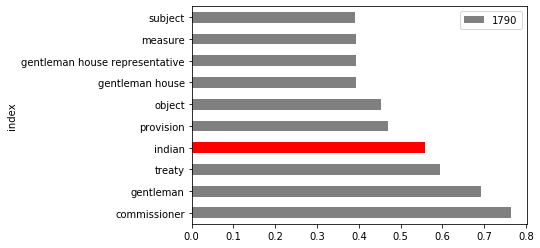

In [105]:
# 1970: indian
colors = ['grey', 'grey', 'grey', 'r', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']
matrix_decade_1790.reset_index().plot(kind='barh', x='index', y='1790', color = colors)

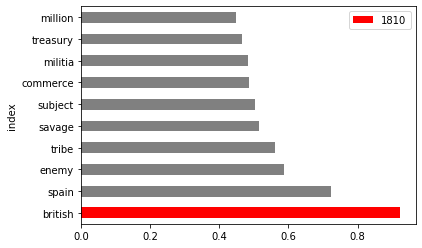

In [108]:
# 1810: British
colors = ['r', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']
matrix_decade_1810.reset_index().plot(kind='barh', x='index', y='1810', color = colors)

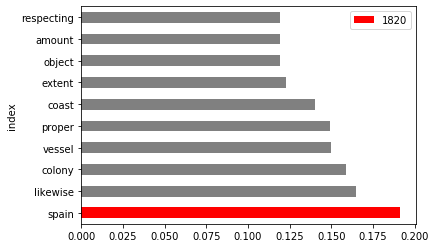

In [111]:
# 1820: Spain
colors = ['r', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']
matrix_decade_1820.reset_index().plot(kind='barh', x='index', y='1820', color = colors)

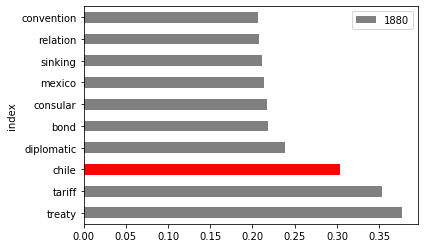

In [113]:
# 1880: Chile
colors = ['grey', 'grey', 'r', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']
matrix_decade_1880.reset_index().plot(kind='barh', x='index', y='1880', color = colors)

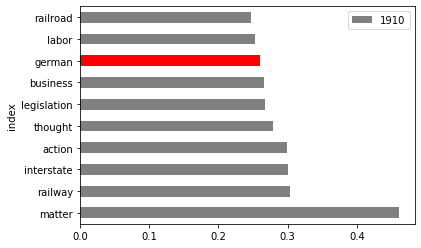

In [115]:
# 1910: German
colors = ['grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'r', 'grey', 'grey']
matrix_decade_1910.reset_index().plot(kind='barh', x='index', y='1910', color = colors)

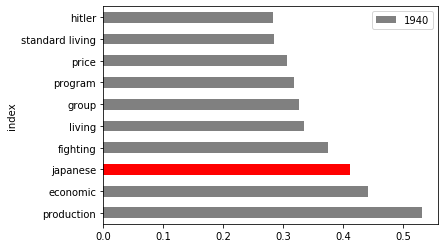

In [117]:
# 1940: Japanese
colors = ['grey', 'grey', 'r', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']
matrix_decade_1940.reset_index().plot(kind='barh', x='index', y='1940', color = colors)

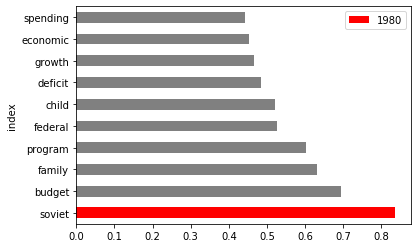

In [119]:
# 1980: Soviet
colors = ['r', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']
matrix_decade_1980.reset_index().plot(kind='barh', x='index', y='1980', color = colors)

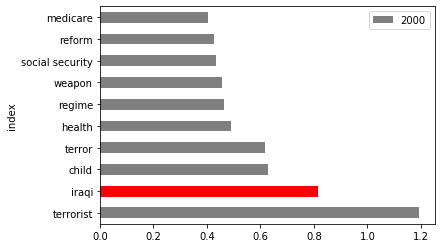

In [121]:
# 2000: Iraqi
colors = ['grey', 'r', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']
matrix_decade_2000.reset_index().plot(kind='barh', x='index', y='2000', color = colors)